**Problem 1 :** Using the images (aerobic-[001-022].bmp) provided on the class materials site,
experiment with simple “motion detection” between consecutive frames using (abs)
image differencing. Clean-up and remove any tiny regions (e.g., use techniques such
as bwareaopen, median filtering, etc.). Experiment with different thresholds. [2 pts]

In [ ]:
# Q2: MEI & MHI
import os, glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

DATA_DIR = "data/"     
PATTERN  = "aerobic-*.bmp"

# Motion mask params (same as Q1)
T        = 0.05               # fixed threshold in [0,1]
MED_K    = 3                  # median filter window (odd)
MIN_SIZE = 20                 # min component size (px)

# MHI params for this sequence (i goes 2..22 -> 21 diffs total)
TAU      = 21                 # decay horizon in steps
DELTA    = 1.0 / TAU          # per-step decay in normalized [0,1]


In [22]:
def load_gray01(path):
    return np.asarray(Image.open(path).convert("L"), np.float32) / 255.0

def load_sequence(data_dir=DATA_DIR, pattern=PATTERN):
    paths = sorted(glob.glob(os.path.join(data_dir, pattern)))
    if not paths: raise FileNotFoundError("No BMPs found.")
    frames = [load_gray01(p) for p in paths]
    return frames, paths

def pad_reflect(a, r):
    return np.pad(a, r, mode="reflect")

def median_filter2d(img, k=3):
    # simple, pure-NumPy median filter (k odd)
    assert k % 2 == 1
    r = k // 2
    P = pad_reflect(img, r)
    H, W = img.shape
    out = np.empty_like(img)
    for y in range(H):
        rows = P[y:y+k]
        win = np.stack([rows[:, x:x+W] for x in range(k)], axis=0)  # k × k × W
        out[y] = np.median(win.reshape(k*k, W), axis=0)
    return out

def remove_small_regions(bw, min_size=MIN_SIZE):
    # 8-connected flood fill; bw is {0,1} or bool
    bw = (bw > 0).astype(np.uint8)
    H, W = bw.shape
    lab = np.zeros_like(bw, np.int32)
    cur = 0
    nbrs = [(-1,-1),(-1,0),(-1,1),(0,-1),(0,1),(1,-1),(1,0),(1,1)]
    from collections import deque
    for y in range(H):
        for x in range(W):
            if bw[y,x] and lab[y,x]==0:
                cur += 1; q = deque([(y,x)]); lab[y,x]=cur; size=0
                while q:
                    cy,cx=q.popleft(); size+=1
                    for dy,dx in nbrs:
                        ny,nx=cy+dy,cx+dx
                        if 0<=ny<H and 0<=nx<W and bw[ny,nx] and lab[ny,nx]==0:
                            lab[ny,nx]=cur; q.append((ny,nx))
                if size < min_size: lab[lab==cur]=0
    return (lab>0).astype(np.uint8)

# ---- shape moments (raw/central/normalized + Hu) ----
def spatial_moments(img):
    """
    img: 2D array in [0,1] (float) or {0,1} (binary). Treated as intensity (MEI/MHI).
    Returns dict with m_ij, mu_ij, eta_ij and 7 Hu invariants.
    """
    I = img.astype(np.float64)
    H, W = I.shape
    yy, xx = np.mgrid[0:H, 0:W]

    m00 = I.sum()
    # guard against empty images
    if m00 <= 1e-12:
        return dict(m00=0, cx=np.nan, cy=np.nan, hu=[np.nan]*7)

    m10 = (xx*I).sum(); m01 = (yy*I).sum()
    cx, cy = m10/m00, m01/m00

    x = xx - cx; y = yy - cy
    mu20 = (x**2 * I).sum(); mu02 = (y**2 * I).sum(); mu11 = (x*y * I).sum()
    mu30 = (x**3 * I).sum(); mu03 = (y**3 * I).sum()
    mu21 = (x**2 * y * I).sum(); mu12 = (x * y**2 * I).sum()

    # normalized central moments (scale invariance)
    eta20 = mu20 / (m00**2)
    eta02 = mu02 / (m00**2)
    eta11 = mu11 / (m00**2)
    eta30 = mu30 / (m00**2.5)
    eta03 = mu03 / (m00**2.5)
    eta21 = mu21 / (m00**2.5)
    eta12 = mu12 / (m00**2.5)

    # Hu invariants (1..7)
    phi1 = eta20 + eta02
    phi2 = (eta20 - eta02)**2 + 4*eta11**2
    phi3 = (eta30 - 3*eta12)**2 + (3*eta21 - eta03)**2
    phi4 = (eta30 + eta12)**2 + (eta21 + eta03)**2
    phi5 = ((eta30 - 3*eta12)*(eta30 + eta12) * ((eta30 + eta12)**2 - 3*(eta21 + eta03)**2) +
            (3*eta21 - eta03)*(eta21 + eta03)*(3*(eta30 + eta12)**2 - (eta21 + eta03)**2))
    phi6 = ((eta20 - eta02)*((eta30 + eta12)**2 - (eta21 + eta03)**2) +
            4*eta11*(eta30 + eta12)*(eta21 + eta03))
    phi7 = ((3*eta21 - eta03)*(eta30 + eta12) * ((eta30 + eta12)**2 - 3*(eta21 + eta03)**2) -
            (eta30 - 3*eta12)*(eta21 + eta03)*(3*(eta30 + eta12)**2 - (eta21 + eta03)**2))

    return dict(
        m00=m00, cx=cx, cy=cy,
        hu=[phi1, phi2, phi3, phi4, phi5, phi6, phi7]
    )


Loaded 22 frames: data/aerobic-001.bmp .. data/aerobic-022.bmp


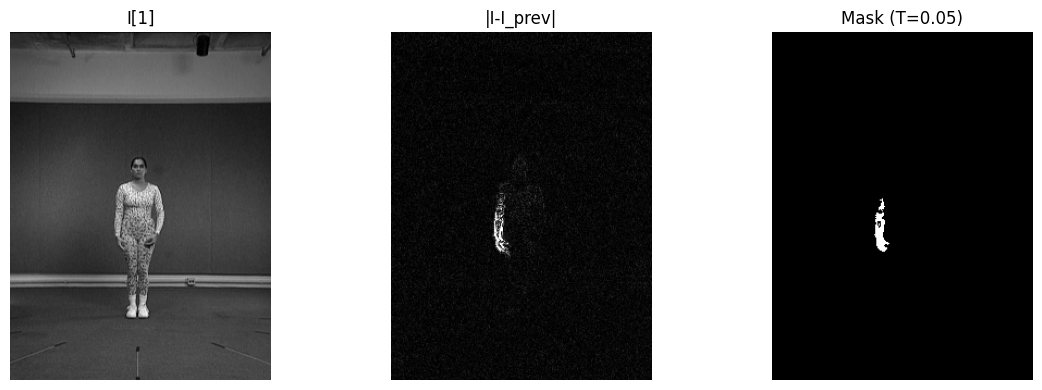

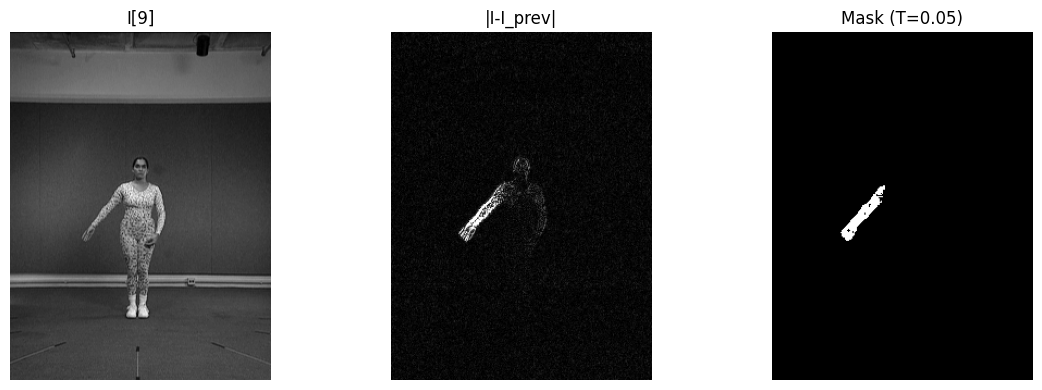

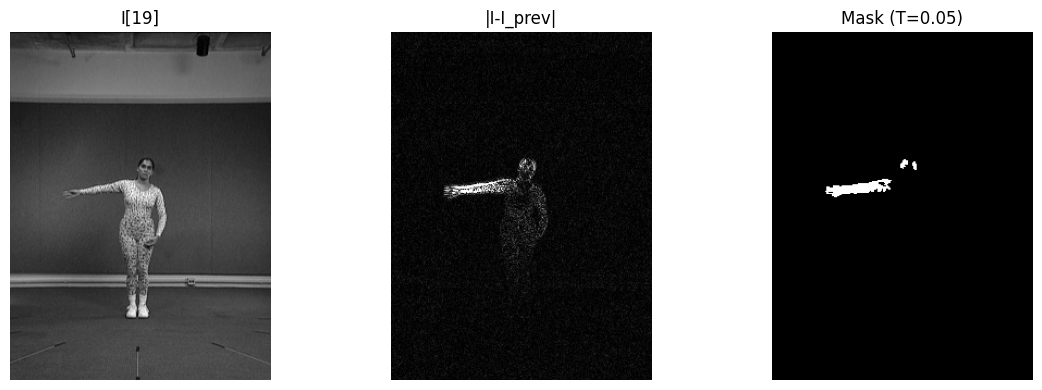

Done Q1.


In [ ]:
# 1) Load sequence
frames, paths = load_sequence()
print(f"Loaded {len(frames)} frames: {paths[0]} .. {paths[-1]}")

# 2) Process consecutive pairs: abs diff -> threshold -> median -> remove small regions
results = []  # (i, mask)
for i in range(1, len(frames)):
    diff = np.abs(frames[i] - frames[i-1])
    mask = (diff >= T).astype(np.uint8)
    if MED_K > 1:
        mask = (median_filter2d(mask.astype(np.float32), k=MED_K) >= 0.5).astype(np.uint8)
    mask = remove_small_regions(mask, min_size=MIN_SIZE)
    results.append((i, mask))

# 3) Quick visual check on a few indices
sample_is = [2, 10, 20] if len(frames) > 20 else [min(2, len(frames)-1)]
for i in sample_is:
    diff = np.abs(frames[i] - frames[i-1])
    fig, ax = plt.subplots(1, 3, figsize=(12,4))
    ax[0].imshow(frames[i-1], cmap="gray"); ax[0].set_title(f"I[{i-1}]"); ax[0].axis("off")
    ax[1].imshow(diff, cmap="gray", vmin=0, vmax=0.2); ax[1].set_title("|I-I_prev|"); ax[1].axis("off")
    mask = dict(results)[i]
    ax[2].imshow(mask, cmap="gray"); ax[2].set_title(f"Mask (T={T})"); ax[2].axis("off")
    plt.tight_layout(); plt.show()

print("Done Q1.")


**Discussion :** Absolute frame differencing with a fixed threshold reliably highlights the moving subject, and a small median filter plus removing tiny 8-connected components cleans speckle while preserving the silhouette.

**Problem 2 :** Compute an MEI and MHI on the image sequence (using your best motion differencing
approach from problem #1 above for each image pair i and i-1), simulating the current
MHI “timestamp” for each image pair using the larger of the image pair index values
(i.e., use i, not i-1). Therefore, you will have difference images from i=2 to 22. The
MEI/MHI duration should include all image diff results in the sequence into the final
template. Use imagesc (Matlab) to show your results. Compute the 7 similitude
moments for the final MEI and the MHI (make sure to normalize the MEI and MHI
values to be between 0-1 before computing the moments using the given formula in the
class notes: max[0, (i-1.0)/21.0] for this example). [4 pts]

Loaded 22 frames; computing masks & MEI/MHI...

MEI:
  area m00 = 3284.0, centroid = (83.72, 163.20)
  Hu (log10-abs): [np.float64(-0.6525978271695901), np.float64(-2.745815789103832), np.float64(-2.0963540557258495), np.float64(-2.76957471311622), np.float64(-5.247600866063608), np.float64(-4.431908402158292), np.float64(5.5661535344977855)]

MHI:
  mass m00 = 1304.1, centroid = (81.97, 145.65)
  Hu (log10-abs): [np.float64(-0.31215926227854474), np.float64(-0.83363196912822), np.float64(-1.1817623767449954), np.float64(-1.4603369270669746), np.float64(-2.781518105438513), np.float64(-1.879153186246054), np.float64(4.390322921860022)]


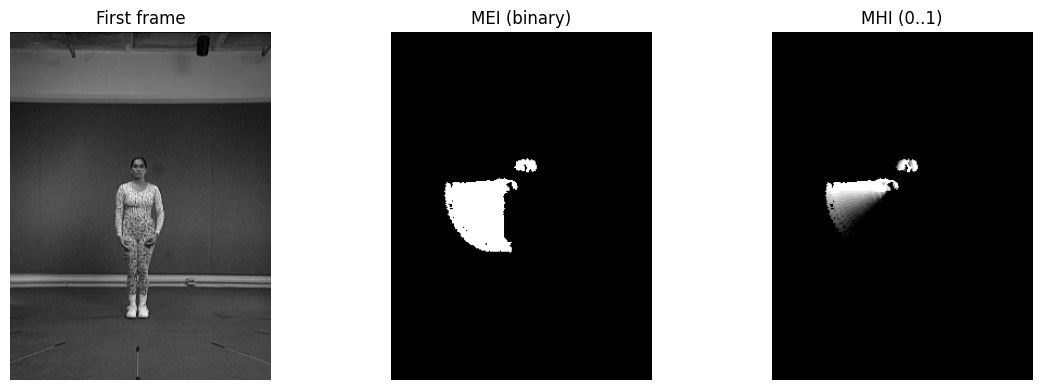

Done Q2.


In [ ]:
# 1) Load frames
frames, fpaths = load_sequence()
H, W = frames[0].shape
print(f"Loaded {len(frames)} frames; computing masks & MEI/MHI...")

# 2) Build motion masks
masks = []  # list of binary masks for i=1..N-1 but we'll index by actual i (2..N)
for i in range(1, len(frames)):
    diff = np.abs(frames[i] - frames[i-1])
    mask = (diff >= T).astype(np.uint8)
    if MED_K > 1:
        mask = (median_filter2d(mask.astype(np.float32), k=MED_K) >= 0.5).astype(np.uint8)
    mask = remove_small_regions(mask, min_size=MIN_SIZE)
    masks.append(mask)

# 3) Compute MEI (binary OR over all masks)
MEI = np.zeros((H, W), np.uint8)
for m in masks:
    MEI |= m

# 4) Compute MHI with decay + timestamp overwrite (normalized 0..1)
#    i runs 2..22 -> normalized timestamp ts = (i-1)/21 ∈ (1/21 .. 1]
MHI = np.zeros((H, W), np.float32)
for k, m in enumerate(masks, start=2):     
    # decay older motion everywhere
    MHI = np.maximum(0.0, MHI - DELTA)
    # stamp current motion with normalized timestamp
    ts = max(0.0, (k - 1.0) / TAU)         
    MHI[m.astype(bool)] = ts

# 5) Moments on MEI & MHI (ensure MHI in [0,1] already)
mei_mom = spatial_moments(MEI.astype(np.float32))
mhi_mom = spatial_moments(MHI)

print("\nMEI:")
print(f"  area m00 = {mei_mom['m00']:.1f}, centroid = ({mei_mom['cx']:.2f}, {mei_mom['cy']:.2f})")
print("  Hu (log10-abs):", [np.sign(h)*np.log10(abs(h)+1e-30) for h in mei_mom['hu']])

print("\nMHI:")
print(f"  mass m00 = {mhi_mom['m00']:.1f}, centroid = ({mhi_mom['cx']:.2f}, {mhi_mom['cy']:.2f})")
print("  Hu (log10-abs):", [np.sign(h)*np.log10(abs(h)+1e-30) for h in mhi_mom['hu']])

# 6) Quick visualization
fig, ax = plt.subplots(1, 3, figsize=(12,4))
ax[0].imshow(frames[0], cmap="gray"); ax[0].set_title("First frame"); ax[0].axis("off")
ax[1].imshow(MEI, cmap="gray");       ax[1].set_title("MEI (binary)"); ax[1].axis("off")
im = ax[2].imshow(MHI, cmap="gray", vmin=0, vmax=1); ax[2].set_title("MHI (0..1)"); ax[2].axis("off")
plt.tight_layout(); plt.show()

print("Done Q2.")


**Discussion :** The MEI accumulates where motion occurred, while the normalized MHI (0–1) encodes when it happened, so their Hu moments emphasize overall action shape versus its recency-weighted sweep.

**Problem 3 :** Create a 101x101 image with a black (0) background and a white (255) box of size
21x21, placing the upper-left corner at pixel (row=40, col=6). Create another new box
image, but shift the box 1-pixel to the right and 1-pixel down. Compute the normal
flow between the images. Use MATLAB’s quiver function to draw the motion
vectors on the image (call imagesc, then ‘hold on’, and lastly call quiver). (Make sure
your gradient mask orientations/directions and the plot axes are consistent!!!) Make
sure all masks are “correct” with proper scaling/normalization. Is the result what you
expected? Why or why not? Comment on the flow for the 4 sides of the box and also
for the 4 corners. [5 pts]

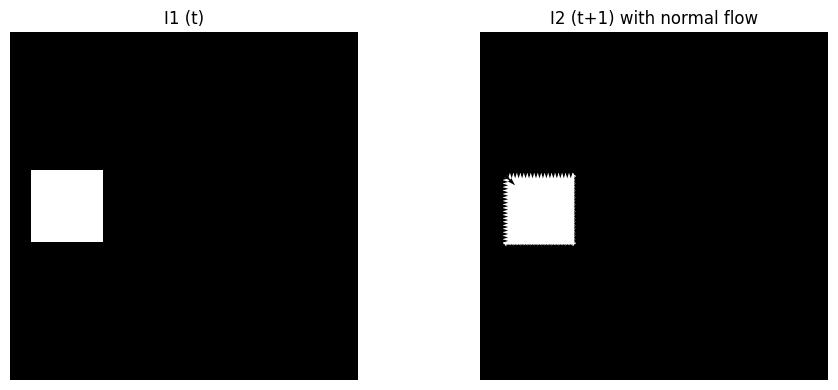

In [25]:


# 1) Build the two images (scale to [0,1] for proper normalization)
H, W = 101, 101
I1 = np.zeros((H, W), dtype=np.float32)
I2 = np.zeros((H, W), dtype=np.float32)

# Box size & positions (upper-left at (row=40, col=6), then shift +1 row, +1 col)
r0, c0, s = 40, 6, 21
I1[r0:r0+s, c0:c0+s] = 1.0
I2[r0+1:r0+1+s, c0+1:c0+1+s] = 1.0  # shifted down/right by 1

# 2) Spatial gradients with properly normalized Sobel masks (/8) on the 2nd frame
#    (slides: classic gradient masks & keep normalization factor) 
#    Fx = [[-1,0,1],[-2,0,2],[-1,0,1]]/8 ; Fy = [[-1,-2,-1],[0,0,0],[1,2,1]]/8
Kx = (1/8.0) * np.array([[-1, 0, 1],
                          [-2, 0, 2],
                          [-1, 0, 1]], dtype=np.float32)
Ky = (1/8.0) * np.array([[-1, -2, -1],
                          [ 0,  0,  0],
                          [ 1,  2,  1]], dtype=np.float32)

def conv2_same(img, k):
    r = k.shape[0]//2
    P = np.pad(img, r, mode="reflect")
    out = np.empty_like(img, dtype=np.float32)
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            out[y, x] = np.sum(P[y:y+2*r+1, x:x+2*r+1] * k, dtype=np.float32)
    return out

Ix = conv2_same(I2, Kx)
Iy = conv2_same(I2, Ky)

# 3) Temporal derivative (It = I2 - I1), dt=1 frame
It = I2 - I1

# 4) Normal flow: solve Ix*u + Iy*v + It = 0 for the component along ∇I
#    v_n = -(It / (Ix^2 + Iy^2)) * [Ix, Iy]
eps  = 1e-12
den  = Ix*Ix + Iy*Iy + eps
U    = -It * Ix / den
V    = -It * Iy / den

# Keep vectors only where spatial gradient is significant (on edges)
mag  = np.sqrt(Ix*Ix + Iy*Iy)
thr  = 0.2 * mag.max()  # show clear edge-only vectors
mask = mag >= thr
U[~mask] = 0.0
V[~mask] = 0.0

# 5) Plot: image then quiver (MATLAB: imagesc; hold on; quiver)
Y, X = np.mgrid[0:H, 0:W]
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].imshow(I1, cmap="gray", vmin=0, vmax=1, origin="upper")
ax[0].set_title("I1 (t)")
ax[0].axis("off")

ax[1].imshow(I2, cmap="gray", vmin=0, vmax=1, origin="upper")
ax[1].quiver(X[mask], Y[mask], U[mask], V[mask],
             angles="xy", scale_units="xy", scale=1)
ax[1].set_title("I2 (t+1) with normal flow")
ax[1].invert_yaxis()   # ensure row+ points downward (image coords)
ax[1].set_aspect("equal")
ax[1].set_xlim(0, W-1); ax[1].set_ylim(H-1, 0)
ax[1].axis("off")

plt.tight_layout()
plt.show()


**Discussion :** Yes. Normal flow only picks up motion straight out from edges, so arrows go sideways on vertical edges and up/down on horizontal edges; corners look messy/weak, and inside the box there are no arrows because there’s no texture to measure.